### Programming Assignment 2
* CSCI-5930 ML Spring 2019  
* Author: Bhuwan Sapkota

## STEP 1

In [1]:
# Import all the necessary packages here
import pandas as pd
from scipy.io import loadmat
import imageio
import numpy as np
from zipfile import ZipFile
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import randint
import math

In [2]:
images = np.empty((60327, 10000))

metaData = loadmat('wiki_labeled', squeeze_me=True, struct_as_record=True)

full_path = metaData['wiki_labeled']['full_path'].item(0)
age = metaData['wiki_labeled']['age'].item(0)

n = 0
m = 1
with ZipFile('./wiki_labeled.zip', 'r') as zip:
    for e in full_path:
        file = zip.open('wiki_labeled/' + e)
        img = Image.open(file)
        ar = np.array(img).flatten()
        images[n:m, :] = ar
#             images[n:m, :] = ar
        n += 1
        m += 1

## STEP 2

In [3]:
XTrain, XTest, yTrain, yTest = train_test_split(images,age,test_size=0.2)

## STEP 3

In [4]:
#centralizing images
meanVec = np.mean(XTrain, axis = 0)

#substracting mean from all faces aka centralizing faces
cenImages = XTrain - meanVec

In [5]:
#covarient matrix of training data
CovMat = np.cov(cenImages.T)

In [6]:
# u,s,v = np.linalg.svd(X_std.T)
eigenVal, eigenVec = np.linalg.eigh(CovMat)

In [7]:
eigenVal.shape, eigenVec.shape

((10000,), (10000, 10000))

In [8]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigenVal[i]), eigenVec[:,i]) for i in range(len(eigenVal))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

## STEP 4

In [9]:
#scaling eigen values to 0-100
tot = sum(eigenVal)
# var_exp = [(i / tot)*100 for i in sorted(eigenVal, reverse=True)]
var_exp = [(eig_pairs[i][0] / tot)*100 for i in range(len(eigenVal))]

In [10]:
top20eigenVal = []
for i in range(0,20):
    top20eigenVal.append(var_exp[i])

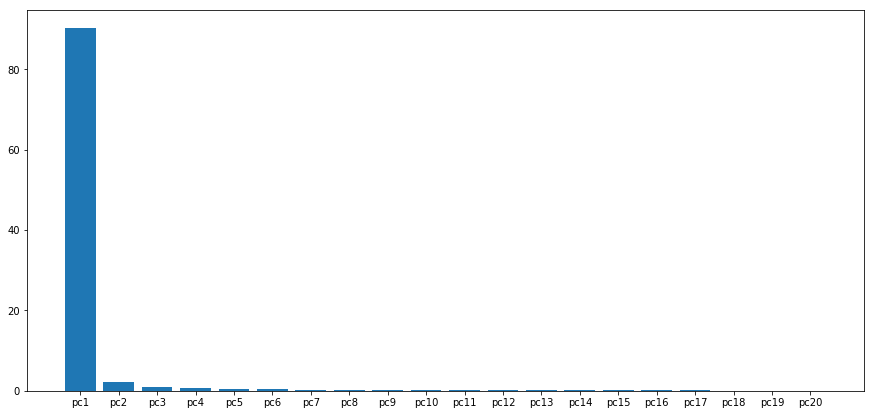

In [11]:
#priniging the graph
labels = []
for i in range(1,21):
    labels.append('pc'+str(i))

plt.figure(figsize=(15,7))
plt.bar(np.arange(len(top20eigenVal)),top20eigenVal)
plt.xticks(np.arange(len(top20eigenVal)),labels)
plt.show()

## STEP 5

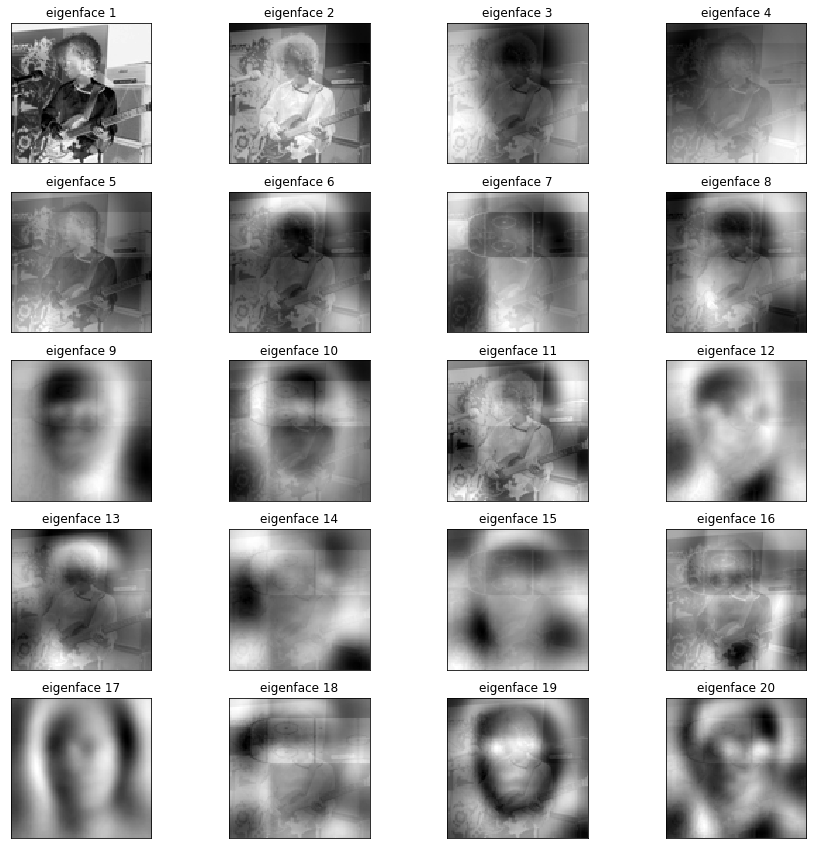

In [12]:
#top 20 eigen faces
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(0, columns*rows):
    img = np.reshape(eig_pairs[i][1],(100,100))
    p = fig.add_subplot(rows, columns, i+1)
    p.set_title('eigenface '+ str(i+1))
    plt.setp(p, xticks=[], yticks=[])
    plt.imshow(img, cmap = "gray")
plt.show()

## STEP 6

In [13]:
K = (10, 20, 40, 50, 60)   # These are the sets of K I will be experimenting with

In [14]:
#Projection Matrix, P\
x = []
for i in range(0,K[0]): 
    x.append(eig_pairs[i][1].reshape(10000,1))


ProjMat = np.hstack(x)

In [15]:
# Now project trainig dataset onto the new feature space through 
# the projection matrix
XTrainProjected = XTrain.dot(ProjMat)

In [16]:
# Projecting testing dataset also to new dimetions
XTestProjected = XTest.dot(ProjMat)

In [17]:
#fit_transform use the statistics from given data and normalize it
scalar = StandardScaler()
scalar.fit(XTrainProjected)                    # using XTrain data to scaling


XTrainProjected = scalar.transform(XTrainProjected)
XTestProjected = scalar.transform(XTestProjected)

## STEP 7

In [18]:
#adding a X0 aka bias column to use the W0
XTrainProjected = np.insert(XTrainProjected, 0, values=1, axis=1)

In [19]:
#defining gradient_decent which will use the batch  

def sgd(XTrain, yTrain, epochs=1000, learningRate=0.001):
    theta= np.ones(XTrain.shape[1])
#     theta = np.random.uniform(low=-5, high=5, size=(XTrain.shape[1],))
    m = len(XTrain)
    tempErr = 0
    
    for it in range(epochs):
        for i in range (m):
            myRand = randint(0, m-1)
            Xcurr = XTrain[myRand,:].reshape(1,XTrain.shape[1])
            Ycurr = yTrain[myRand].reshape(1,1)
            h = np.dot(Xcurr,theta)
            error = h - Ycurr
#             gradient = XTrain.T.dot(error)
            theta = theta - (1/m) * learningRate * (Xcurr.T.dot(error).flatten())
        if (it % 100)==0:
            tempPredict = np.dot(XTrain,theta)
            tempErr = np.abs(np.mean(tempPredict-yTrain))
            print ("Average Error on " + str(it) + " epochs: "+ str(tempErr))
    print ("\nFinal average Error : " + str(tempErr) + "\n")
    return theta

In [20]:
#finding hyper parameters aka weights
#after doing some hit and trial 600 epoch were good becasue it no longer
#conversing
# I tried 0.001 learining rate but that was too slow. just by visual
# inspection 0.01 should be enough
Weight = sgd(XTrainProjected,yTrain,600, 0.01)

Average Error on 0 epochs: 35.37550884411023
Average Error on 100 epochs: 13.016805993244327
Average Error on 200 epochs: 4.802864487377297
Average Error on 300 epochs: 1.775733324034627
Average Error on 400 epochs: 0.65141268612368
Average Error on 500 epochs: 0.2422837849152479

Final average Error : 0.2422837849152479



In [21]:
# final weights after training SGD
Weight

array([ 3.66497800e+01,  3.05696525e-01,  9.17659387e-01, -3.10981190e+00,
       -1.67316506e+00, -1.64148444e+00,  2.58648794e+00,  2.29512398e+00,
        1.59357068e+00,  1.08837775e-02, -5.95562501e-01])

## STEP 8

In [22]:
# inserting column of 1 in from of Test data to deal with the Theta 0 in the calculation
XTestProjected = np.insert(XTestProjected, 0, values=1, axis=1)

In [23]:
TestPrediction = np.dot(XTestProjected,Weight)

In [24]:
RMSE = np.sqrt(np.mean((TestPrediction - yTest)**2))

RMSEs = []
RMSEs.append(RMSE)
RMSEs

[19.9921788772882]

## STEP 9

In [25]:
metaDataJ = loadmat('wiki_judgeX', squeeze_me=True, struct_as_record=True)

full_path_J = metaDataJ['wiki_judgeX']['full_path'].item(0)

#makind judge data ready
n = (len(full_path_J), 10000)
imagesJ = np.empty(n)

n = 0
m = 1

with ZipFile('./wiki_judge_images.zip', 'r') as zip:
    for e in full_path_J:
        file = zip.open('wiki_judge_images/' + e)
        img = Image.open(file)
        ar = np.array(img).flatten()
        imagesJ[n:m, :] = ar
#             images[n:m, :] = ar
        n += 1
        m += 1

In [26]:
#centralized imagees using training mean vector
centeredImagesJ = imagesJ - meanVec

In [27]:
# Now project trainig dataset onto the new feature space through 
# the projection matrix
centeredImagesProjectedJ = centeredImagesJ.dot(ProjMat)

In [28]:
#scaling              # using XTrain data to normalization
scalarJ = StandardScaler()
scalarJ.fit(centeredImagesProjectedJ) 
centeredImagesProjectedJ = scalarJ.transform(centeredImagesProjectedJ)

In [29]:
#adding bias 
centeredImagesProjectedJ = np.insert(centeredImagesProjectedJ, 0, values=1, axis=1)

In [30]:
#finally predicting the age
predictAgeJ = np.dot(centeredImagesProjectedJ,Weight)

In [31]:
# exporting the predition to csv file

ID = metaDataJ['wiki_judgeX']['ID'].item(0)

#transposing the output column
predictAgeJ = predictAgeJ.reshape((-1, 1))
ID = ID.reshape((-1, 1))

#concatinating ID and prediction)) #concatinating ID and prediction
result = np.hstack((ID,predictAgeJ))

header=["ID","age"]    #header name

#making dataframe ready to write to csv
df2 = pd.DataFrame(data=result,columns=header) 
df2.ID = df2.ID.astype('int64') 

df2.to_csv('submission.csv', sep=',',index=False)   #printing to csv.

## STEP 10



****************************************************************************************
*********************                 ROUND: 1              ****************************
*********************       value of K on this round : 20   ****************************
****************************************************************************************




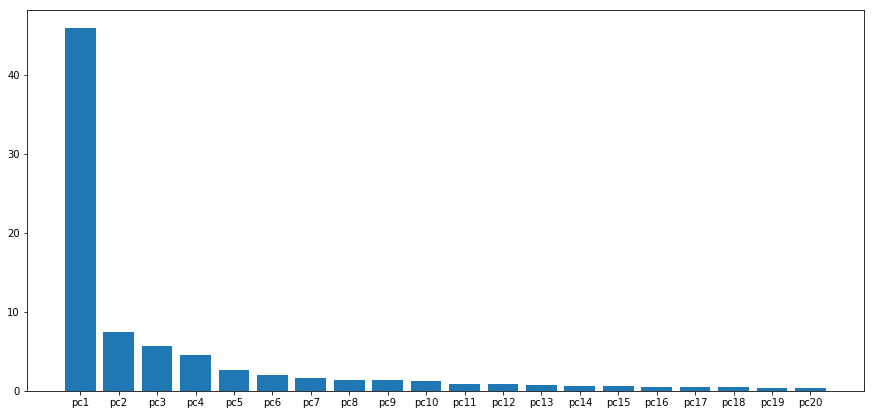

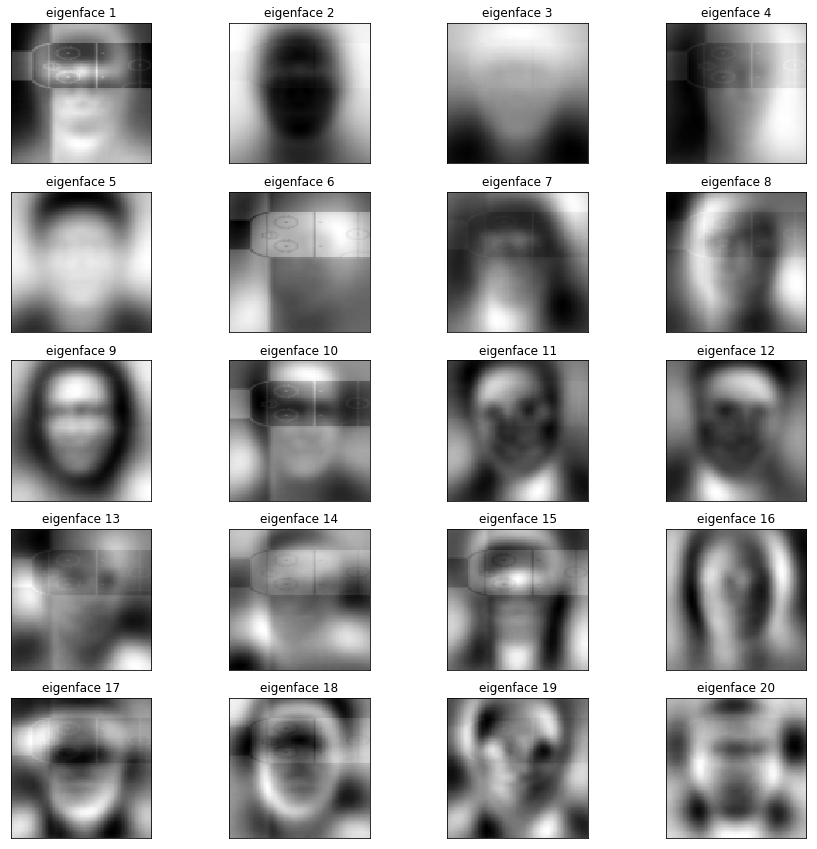

Average Error on 0 epochs: 35.35616573309395
Average Error on 100 epochs: 13.00029233635803
Average Error on 200 epochs: 4.785184090261812
Average Error on 300 epochs: 1.7580038522962227
Average Error on 400 epochs: 0.6541887998344202
Average Error on 500 epochs: 0.23367555929639688

Final average Error : 0.23367555929639688



****************************************************************************************
*********************                 ROUND: 2              ****************************
*********************       value of K on this round : 40   ****************************
****************************************************************************************




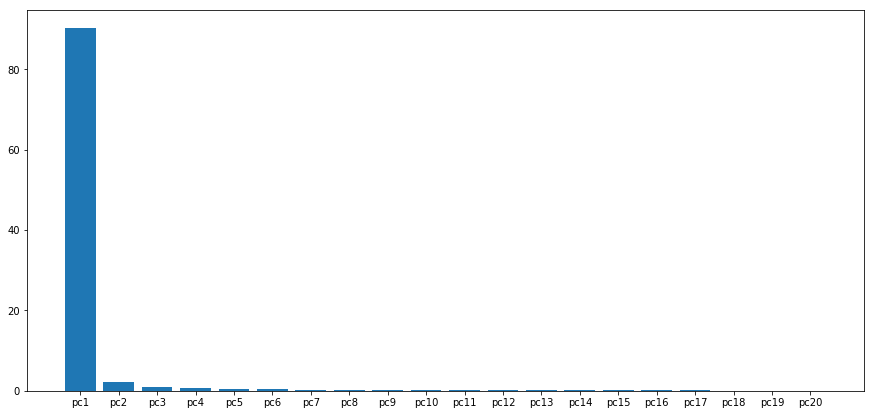

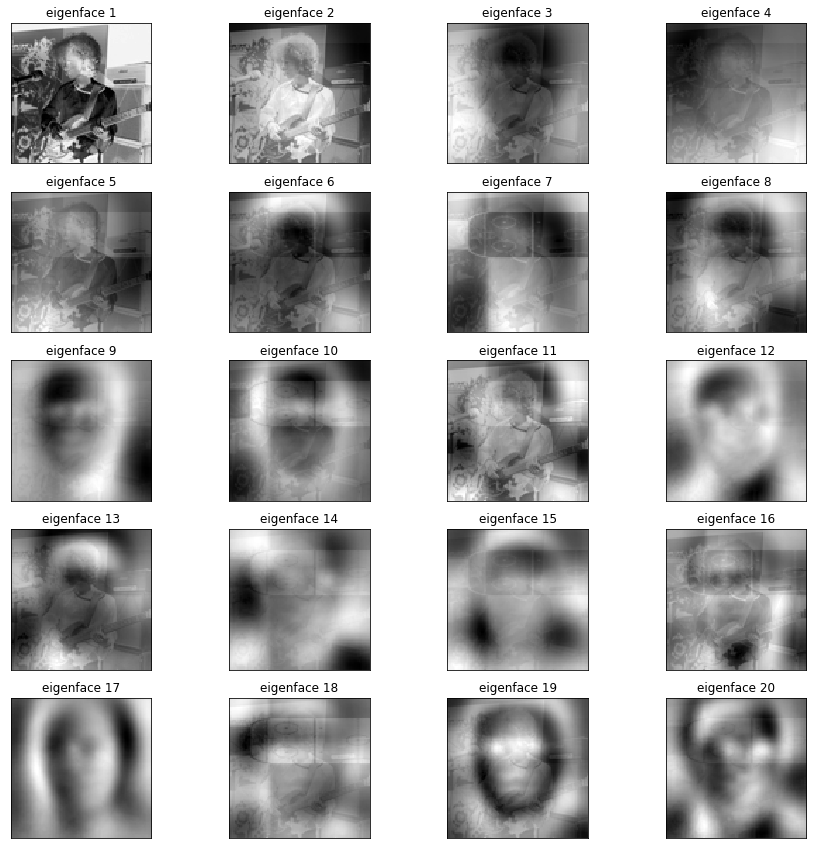

Average Error on 0 epochs: 35.346552069228736
Average Error on 100 epochs: 13.009910561376401
Average Error on 200 epochs: 4.790280973004126
Average Error on 300 epochs: 1.758875068829605
Average Error on 400 epochs: 0.6543985598250995
Average Error on 500 epochs: 0.2508821071340922

Final average Error : 0.2508821071340922



****************************************************************************************
*********************                 ROUND: 3              ****************************
*********************       value of K on this round : 50   ****************************
****************************************************************************************




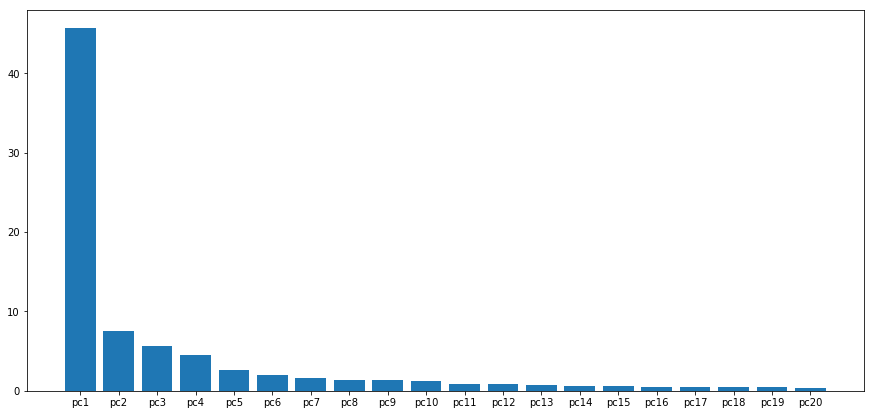

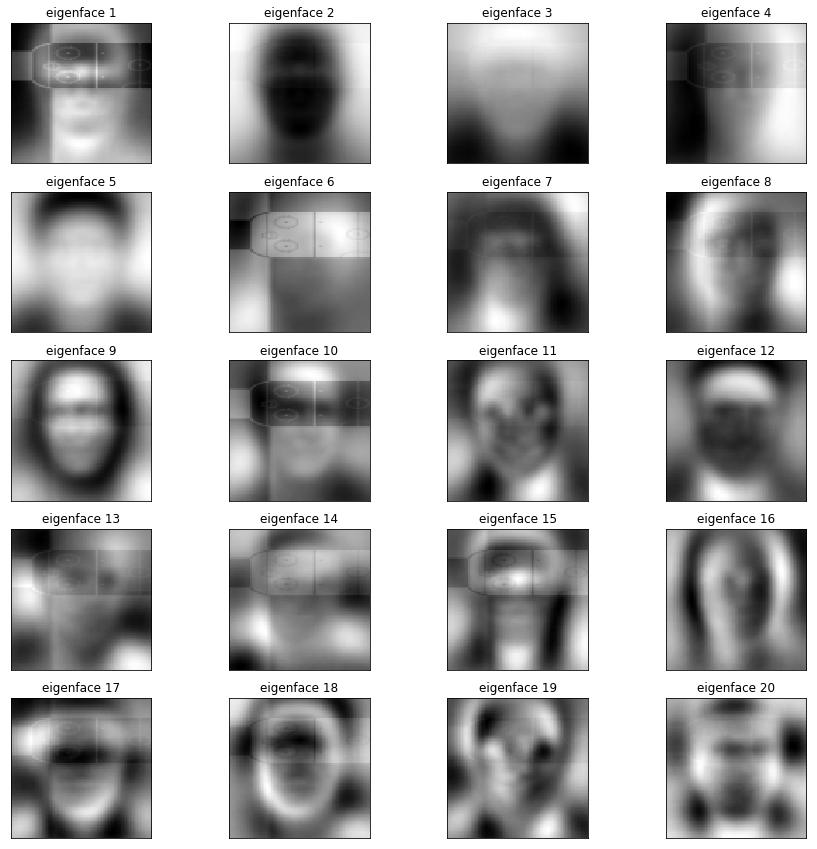

Average Error on 0 epochs: 35.31740558611615
Average Error on 100 epochs: 12.994386620670133
Average Error on 200 epochs: 4.7876620539715455
Average Error on 300 epochs: 1.7612164473183713
Average Error on 400 epochs: 0.6487746554788968
Average Error on 500 epochs: 0.2397502648770492

Final average Error : 0.2397502648770492



****************************************************************************************
*********************                 ROUND: 4              ****************************
*********************       value of K on this round : 60   ****************************
****************************************************************************************




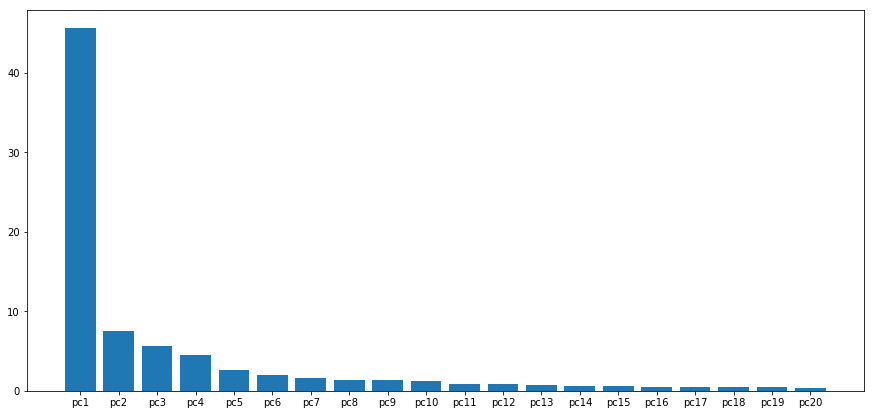

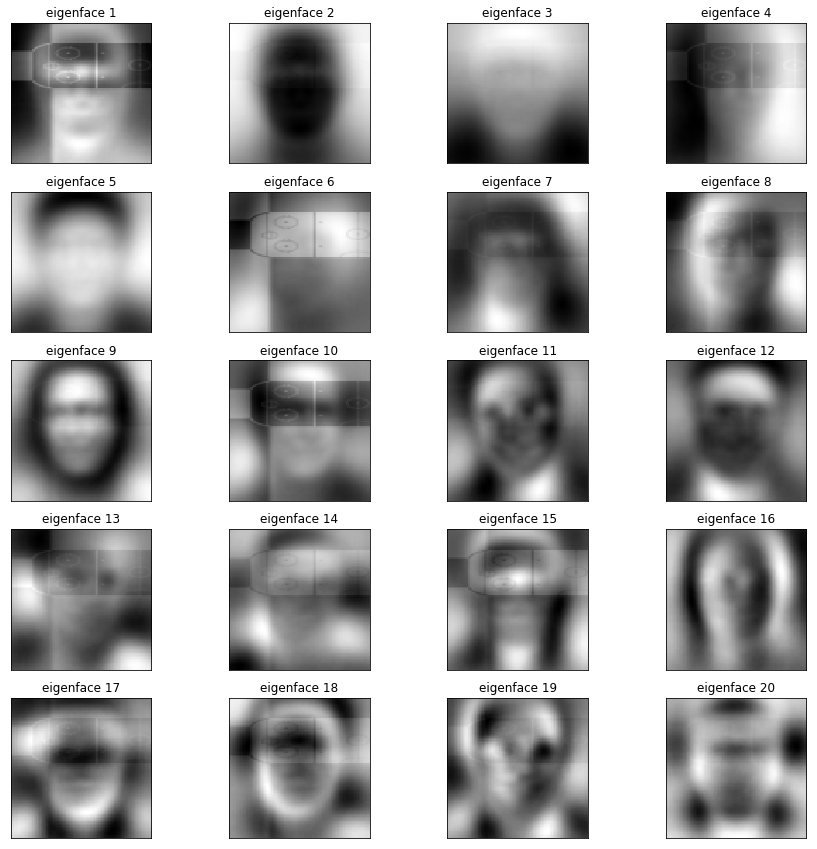

Average Error on 0 epochs: 35.35633966539305
Average Error on 100 epochs: 13.01121363999622
Average Error on 200 epochs: 4.787050614083996
Average Error on 300 epochs: 1.7545608549124507
Average Error on 400 epochs: 0.6450597891212572
Average Error on 500 epochs: 0.23742178212121876

Final average Error : 0.23742178212121876

final RMSEs:[19.9921788772882, 21.66474245884043, 19.79700773620871, 21.994831645614365, 24.4122279457925]


In [32]:
for r in range (0,4):
    print("\n\n****************************************************************************************")
    print("*********************                 ROUND: "+ str(r+1) + "              ****************************")
    print("*********************       value of K on this round : "+ str(K[r+1]) + "   ****************************")
    print("****************************************************************************************\n\n")
    XTrain, XTest, yTrain, yTest = train_test_split(images,age,test_size=0.2)

    #centralizing images
    meanVec = np.mean(XTrain, axis = 0)

    #substracting mean from all faces aka centralizing faces
    cenImages = XTrain - meanVec

    #covarient matrix of training data
    CovMat = np.cov(cenImages.T)

    # u,s,v = np.linalg.svd(X_std.T)
    eigenVal, eigenVec = np.linalg.eigh(CovMat)

    # Make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eigenVal[i]), eigenVec[:,i]) for i in range(len(eigenVal))]

    # Sort the (eigenvalue, eigenvector) tuples from high to low
    eig_pairs.sort()
    eig_pairs.reverse()

    #scaling eigen values to 0-100
    tot = sum(eigenVal)
    # var_exp = [(i / tot)*100 for i in sorted(eigenVal, reverse=True)]
    var_exp = [(eig_pairs[i][0] / tot)*100 for i in range(len(eigenVal))]

    top20eigenVal = []
    for i in range(0,20):
        top20eigenVal.append(var_exp[i])

    #priniging the graph
    labels = []
    for i in range(1,21):
        labels.append('pc'+str(i))

    plt.figure(figsize=(15,7))
    plt.bar(np.arange(len(top20eigenVal)),top20eigenVal)
    plt.xticks(np.arange(len(top20eigenVal)),labels)
    plt.show()

    ## STEP 5

    #top 20 eigen faces
    fig=plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5
    for i in range(0, columns*rows):
        img = np.reshape(eig_pairs[i][1],(100,100))
        p = fig.add_subplot(rows, columns, i+1)
        p.set_title('eigenface '+ str(i+1))
        plt.setp(p, xticks=[], yticks=[])
        plt.imshow(img, cmap = "gray")
    plt.show()

    ## STEP 6

    #Projection Matrix, P\
    x = []
    for i in range(0,K[r+1]): 
        x.append(eig_pairs[i][1].reshape(10000,1))


    ProjMat = np.hstack(x)

    # Now project trainig dataset onto the new feature space through 
    # the projection matrix
    XTrainProjected = XTrain.dot(ProjMat)

    # Projecting testing dataset also to new dimetions
    XTestProjected = XTest.dot(ProjMat)

    #fit_transform use the statistics from given data and normalize it
    scalar = StandardScaler()
    scalar.fit(XTrainProjected)                    # using XTrain data to scaling


    XTrainProjected = scalar.transform(XTrainProjected)
    XTestProjected = scalar.transform(XTestProjected)

    ## STEP 7

    #adding a X0 aka bias column to use the W0
    XTrainProjected = np.insert(XTrainProjected, 0, values=1, axis=1)

    #finding hyper parameters aka weights
    #after doing some hit and trial 600 epoch were good becasue it no longer
    #conversing
    # I tried 0.001 learining rate but that was too slow. just by visual
    # inspection 0.01 should be enough
    Weight = sgd(XTrainProjected,yTrain,600, 0.01)

    ## STEP 8

    # inserting column of 1 in from of Test data to deal with the Theta 0 in the calculation
    XTestProjected = np.insert(XTestProjected, 0, values=1, axis=1)

    TestPrediction = np.dot(XTestProjected,Weight)

    RMSE = np.sqrt(np.mean((TestPrediction - yTest)**2))

    RMSEs.append(RMSE)
print("final RMSEs:" + str(RMSEs))

## STEP 11

No handles with labels found to put in legend.


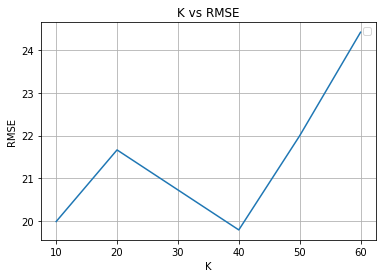

In [33]:
#ploting the graph K vs RMSE
plt.plot(K, RMSEs)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.title('K vs RMSE')
plt.legend()
plt.grid(True)
plt.show()

## STEP 12

In [34]:
# I have submitted results on kaggle
# my handle is Bhuwan


## STEP 13   (EXTRA CREDIT)

In [35]:
metaData = loadmat('wiki_labeled', squeeze_me=True, struct_as_record=True)

full_path = metaData['wiki_labeled']['full_path'].item(0)
#age = metaData['wiki_labeled']['age'].item(0)

full_path.shape

path = []
age = []
i = 0
for f in full_path:
    if not math.isinf(metaData['wiki_labeled']['face_score'].item(0)[i]):
        if math.isnan(metaData['wiki_labeled']['second_face_score'].item(0)[i]):
            if not math.isnan(metaData['wiki_labeled']['gender'].item(0)[i]):
                path.append(f)
                age.append(metaData['wiki_labeled']['age'].item(0)[i])
    i += 1

In [36]:
images = np.empty((len(age), 10000))
n = 0
m = 1
with ZipFile('./wiki_labeled.zip', 'r') as zip:
    for e in path:
        file = zip.open('wiki_labeled/' + e)
        img = Image.open(file)
        ar = np.array(img).flatten()
        images[n:m, :] = ar
#             images[n:m, :] = ar
        n += 1
        m += 1

In [37]:
XTrain, XTest, yTrain, yTest = train_test_split(images,age,test_size=0.2)

In [38]:
#centralizing images
meanVec = np.mean(XTrain, axis = 0)

#substracting mean from all faces aka centralizing faces
cenImages = XTrain - meanVec

In [39]:
#covarient matrix of training data
CovMat = np.cov(cenImages.T)

In [40]:
# u,s,v = np.linalg.svd(X_std.T)
eigenVal, eigenVec = np.linalg.eigh(CovMat)

In [41]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigenVal[i]), eigenVec[:,i]) for i in range(len(eigenVal))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort()
eig_pairs.reverse()

In [42]:
#scaling eigen values to 0-100
tot = sum(eigenVal)
# var_exp = [(i / tot)*100 for i in sorted(eigenVal, reverse=True)]
var_exp = [(eig_pairs[i][0] / tot)*100 for i in range(len(eigenVal))]

In [43]:
top20eigenVal = []
for i in range(0,20):
    top20eigenVal.append(var_exp[i])

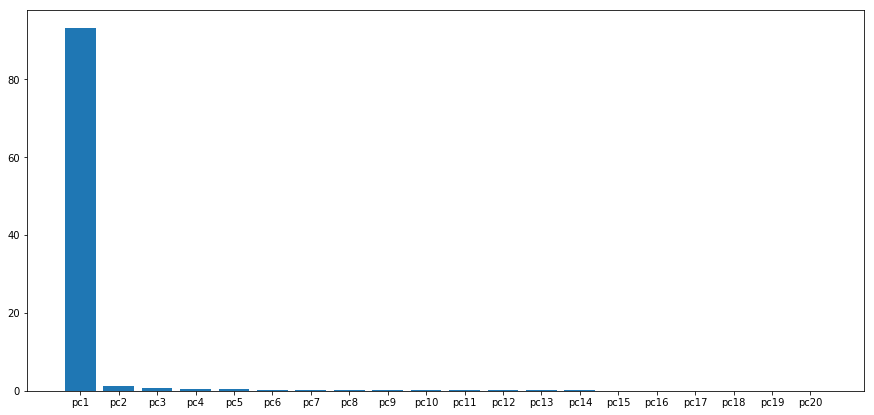

In [44]:
#priniging the graph
labels = []
for i in range(1,21):
    labels.append('pc'+str(i))

plt.figure(figsize=(15,7))
plt.bar(np.arange(len(top20eigenVal)),top20eigenVal)
plt.xticks(np.arange(len(top20eigenVal)),labels)
plt.show()

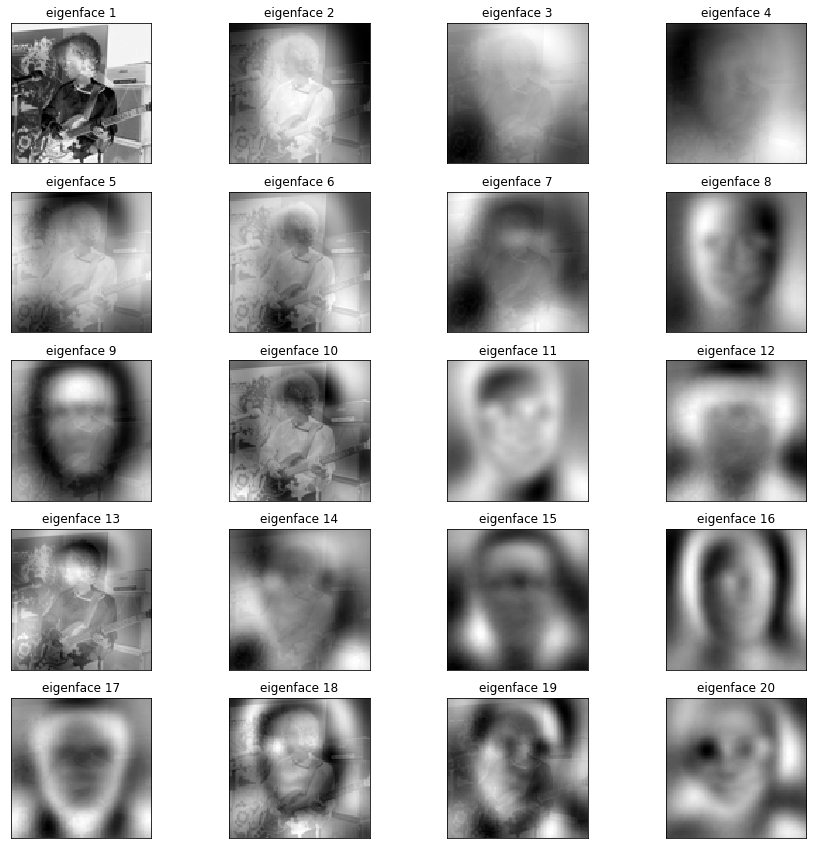

In [45]:
#top 20 eigen faces
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(0, columns*rows):
    img = np.reshape(eig_pairs[i][1],(100,100))
    p = fig.add_subplot(rows, columns, i+1)
    p.set_title('eigenface '+ str(i+1))
    plt.setp(p, xticks=[], yticks=[])
    plt.imshow(img, cmap = "gray")
plt.show()

In [46]:
K = 20   # I am considering 20 eigen values

In [47]:
#Projection Matrix, P\
x = []
for i in range(0,K): 
    x.append(eig_pairs[i][1].reshape(10000,1))


ProjMat = np.hstack(x)

In [48]:
# Now project trainig dataset onto the new feature space through 
# the projection matrix
XTrainProjected = XTrain.dot(ProjMat)

In [49]:
# Projecting testing dataset also to new dimetions
XTestProjected = XTest.dot(ProjMat)

In [50]:
#fit_transform use the statistics from given data and normalize it
scalar = StandardScaler()
scalar.fit(XTrainProjected)                    # using XTrain data to scaling


XTrainProjected = scalar.transform(XTrainProjected)
XTestProjected = scalar.transform(XTestProjected)

In [51]:
#adding a X0 aka bias column to use the W0
XTrainProjected = np.insert(XTrainProjected, 0, values=1, axis=1)

## STEP 14

In [52]:
#defining gradient_decent which will use the mini batch  

def mini_batch(XTrain, yTrain, epochs=1000, learningRate=0.001, batchSize = 32):
    theta= np.ones(XTrain.shape[1])
#     theta = np.random.uniform(low=-5, high=5, size=(XTrain.shape[1],))
    m = len(XTrain)
    tempErr = 0
    
    XRand = np.random.permutation(XTrain)
    yRand = np.random.permutation(yTrain)

    for it in range(epochs):
        for i in range (0,m, batchSize):
            XcurrBatch = XTrain[i:i+batchSize]
            ycurrBatch = yTrain[i:i+batchSize]
            y_hat = np.dot(XcurrBatch,theta)
            errors = y_hat - ycurrBatch
#             gradient = XTrain.T.dot(error)
            theta = theta - (1/m) * learningRate * (XcurrBatch.T.dot(errors))
        if (it % 100)==0:
            tempPredict = np.dot(XTrain,theta)
            tempErr = np.abs(np.mean(tempPredict-yTrain))
            print ("Average Error on " + str(it) + " epochs: "+ str(tempErr))
    print ("\nFinal Average Error: " + str(tempErr) + "\n")
    return theta

In [53]:
#finding hyper parameters aka weights
#after doing some hit and trial 600 epoch were good becasue it no longer
#conversing
# I tried 0.005 learining rate but that was too slow. just by visual
# inspection 0.05 should be enough
Weight = mini_batch(XTrainProjected,yTrain,2000, 0.005, 128)

Average Error on 0 epochs: 37.08997284187472
Average Error on 100 epochs: 22.496028226797364
Average Error on 200 epochs: 13.644407946060834
Average Error on 300 epochs: 8.275661957293785
Average Error on 400 epochs: 5.019372985963341
Average Error on 500 epochs: 3.0443460635803716
Average Error on 600 epochs: 1.84643906595706
Average Error on 700 epochs: 1.1198762231819728
Average Error on 800 epochs: 0.6791962992224946
Average Error on 900 epochs: 0.4119120617243351
Average Error on 1000 epochs: 0.24979697604175613
Average Error on 1100 epochs: 0.15146981220296013
Average Error on 1200 epochs: 0.09183174021240482
Average Error on 1300 epochs: 0.05565964399051523
Average Error on 1400 epochs: 0.03372029381217947
Average Error on 1500 epochs: 0.020413487277969412
Average Error on 1600 epochs: 0.012342550867095183
Average Error on 1700 epochs: 0.007447310645700997
Average Error on 1800 epochs: 0.004478215659800711
Average Error on 1900 epochs: 0.002677379615667858

Final Average Error: 

In [54]:
# inserting column of 1 in from of Test data to deal with the Theta 0 in the calculation
XTestProjected = np.insert(XTestProjected, 0, values=1, axis=1)

In [55]:
TestPrediction = np.dot(XTestProjected,Weight)

In [56]:
RMSE = np.sqrt(np.mean((TestPrediction - yTest)**2))
RMSE

16.169254899787287

In [57]:
metaDataJ = loadmat('wiki_judgeX', squeeze_me=True, struct_as_record=True)

full_path_J = metaDataJ['wiki_judgeX']['full_path'].item(0)

#makind judge data ready
n = (len(full_path_J), 10000)
imagesJ = np.empty(n)

n = 0
m = 1

with ZipFile('./wiki_judge_images.zip', 'r') as zip:
    for e in full_path_J:
        file = zip.open('wiki_judge_images/' + e)
        img = Image.open(file)
        ar = np.array(img).flatten()
        imagesJ[n:m, :] = ar
#             images[n:m, :] = ar
        n += 1
        m += 1

In [58]:
#centralized imagees using training mean vector
centeredImagesJ = imagesJ - meanVec

In [59]:
# Now project trainig dataset onto the new feature space through 
# the projection matrix
centeredImagesProjectedJ = centeredImagesJ.dot(ProjMat)

In [60]:
#scaling              # using XTrain data to normalization
scalarJ = StandardScaler()
scalarJ.fit(centeredImagesProjectedJ) 
centeredImagesProjectedJ = scalarJ.transform(centeredImagesProjectedJ)

In [61]:
#adding bias 
centeredImagesProjectedJ = np.insert(centeredImagesProjectedJ, 0, values=1, axis=1)

In [62]:
#finally predicting the age
predictAgeJ = np.dot(centeredImagesProjectedJ,Weight)

In [63]:
# exporting the predition to csv file

ID = metaDataJ['wiki_judgeX']['ID'].item(0)

#transposing the output column
predictAgeJ = predictAgeJ.reshape((-1, 1))
ID = ID.reshape((-1, 1))

#concatinating ID and prediction)) #concatinating ID and prediction
result = np.hstack((ID,predictAgeJ))

header=["ID","age"]    #header name

#making dataframe ready to write to csv
df2 = pd.DataFrame(data=result,columns=header) 
df2.ID = df2.ID.astype('int64') 

df2.to_csv('submission.csv', sep=',',index=False)   #printing to csv.